In [197]:
import numpy as np 
from tqdm import tqdm
import os
import glob
import pandas as pd 
import time
import datetime
import matplotlib.pyplot as plt
from sunpy.coordinates import frames
from astropy.io import fits
import warnings
warnings.filterwarnings("ignore")
import re
from skimage.transform import resize
import seaborn as sns
%matplotlib inline

In [2]:
sunspots = pd.read_pickle('sunspot_1996_2017.pkl')
sunspots.head()

number_of_ss size class location magn_class
date       region                                            
1996-06-04 7968              3    0   AXX   N02E41          A
1996-06-05 7968              2   10   BXO   N02E28          B
           7969              1    0   AXX   N09W33          A
1996-06-06 7968              4   20   CRO   N03E12          B
           7969              4   10   BXO   N08W44          B

In [19]:
def show_fits(filepath):
    #Потом из директории загружаем и делаем, что хотим
    hdulist = fits.open(filepath)
    fits_data =  hdulist[0].data
    #fits_data = np.sign(fits_data)*np.log1p(np.abs(fits_data))
    plt.imshow(fits_data,cmap = plt.get_cmap('gray')); plt.title(filepath)
    return fits_data
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [78]:
def rewrite_mdi(filepath, path_to_write):
    """
    take mdi file, and crop center with size 125x100, what corresponds hmi 500x400
    
    """
    filename = 'r'+str.split(filepath,'/')[-1]
    if not os.path.exists(os.path.join(path_to_write,filename)):

        hdulist = fits.open(filepath)
        fits_data =  hdulist[0].data
        fits_data = crop_center(fits_data,125,100)
        if ~np.isnan(fits_data).all():
            print('Write ',filename,'...')
            hdu = fits.PrimaryHDU(fits_data)
            hdul = fits.HDUList([hdu])
            hdul.writeto(os.path.join(path_to_write,filename))
def rewrite_hmi(filepath, path_to_write):
    """
    take hmi file, and save it with resolution 125x100
    
    """
    filename = 'r'+str.split(filepath,'/')[-1]
    if not os.path.exists(os.path.join(path_to_write,filename)):
        hdulist = fits.open(filepath)
        fits_data =  hdulist[0].data
        fits_data = resize(fits_data,(100,125))
        if ~np.isnan(fits_data).all():
            print('Write ',filename,'...')

            hdu = fits.PrimaryHDU(fits_data)
            hdul = fits.HDUList([hdu])
        
            hdul.writeto(os.path.join(path_to_write,filename))


In [75]:
dataPath = '/Users/Irisha1/Google Drive/_SolarData/!SOHO_MDI'

In [76]:
hmiFiles = glob.glob(os.path.join(dataPath,"HMIfragments/*.fits"))
mdiFiles = glob.glob(os.path.join(dataPath,"MDIfragments/*.fits"))

In [81]:
path_to_write = '/Users/Irisha1/Google Drive/_SolarData/!SOHO_MDI/Allrescaled'
filename = 'r'+str.split(hmiFiles[0],'/')[-1]
#os.path.exists(os.path.join(path_to_write,filename))
#for file in hmiFiles:
#    rewrite_hmi(file, path_to_write)
#for file in mdiFiles:
#    rewrite_mdi(file, path_to_write)

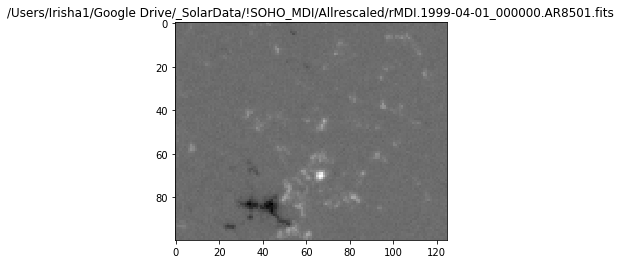

In [178]:
allFiles = glob.glob(os.path.join(path_to_write,"*.fits"))
rdata = show_fits(allFiles[0])

In [179]:
def compute_max_min(filepath):
    hdulist = fits.open(filepath)
    fits_data =  hdulist[0].data
    return np.max(fits_data), np.min(fits_data) 
def extract_date_ar(filepath, type_='hmi'):
    info_str = str.split(filepath,'/')[-1]
    info_str = str.split(info_str,'.')
    max_, min_= compute_max_min(filepath)
    return [pd.to_datetime(info_str[1], format='%Y-%m-%d_%H%M%S'), int(info_str[2][2:]), info_str[0][1:], max_,min_]
def constr_filename(date,region, instr_type):
    return 'r'+str(instr_type)+'.'+date.strftime('%Y-%m-%d_%H%M%S')+'.AR'+str(region)+'.fits'

In [180]:
all_list = [] 
for filename in tqdm(allFiles):
    all_list.append(extract_date_ar(filename))

100%|██████████| 19565/19565 [02:33<00:00, 127.79it/s]


In [182]:
df = pd.DataFrame(all_list, columns  = ['date','region','instr_type','max','min'])
df.set_index(['date','region'], inplace=True)
df.sort_values(by = 'date', inplace=True)

In [183]:
df.head(10)

instr_type     max      min
date       region                            
1996-06-10 7971          MDI  650.25  -263.82
1996-06-27 7973          MDI  635.91 -2353.96
           7976          MDI  423.33 -1444.87
1996-06-28 7976          MDI  569.68 -1676.75
           7973          MDI  448.23 -2075.18
1996-06-29 7976          MDI  720.84 -1770.11
1996-06-30 7976          MDI  698.44 -1235.68
1996-07-01 7976          MDI  560.22  -630.05
1996-07-03 7977          MDI  801.72  -702.63
1996-07-04 7977          MDI  277.21  -593.06

In [184]:
df = df.merge(sunspots, how = 'left', left_on=['date','region'], right_on = ['date','region'])

In [193]:
df['letter_1'] = df['class'].apply(lambda x: x[0])
df['letter_2'] = df['class'].apply(lambda x: x[1])
df['letter_3'] = df['class'].apply(lambda x: x[2])

In [195]:
df.head()

instr_type     max      min number_of_ss size class  \
date       region                                                       
1996-06-10 7971          MDI  650.25  -263.82            2   10   BXO   
1996-06-27 7973          MDI  635.91 -2353.96            1   70   HSX   
           7976          MDI  423.33 -1444.87            4   10   AXX   
1996-06-28 7976          MDI  569.68 -1676.75            4   20   HRX   
           7973          MDI  448.23 -2075.18            1   70   HSX   

                  location magn_class letter_1 letter_2 letter_3  
date       region                                                 
1996-06-10 7971     S07W15          B        B        X        O  
1996-06-27 7973     N09W21          A        H        S        X  
           7976     N13E25          A        A        X        X  
1996-06-28 7976     N13E11          A        H        R        X  
           7973     N08W35          A        H        S        X

In [209]:
df.to_pickle(os.path.join(dataPath,'infoDf.pkl'))

In [187]:
df.instr_type.value_counts()

MDI    12944
HMI     6621
Name: instr_type, dtype: int64

In [227]:
df.shape

(19565, 11)

In [208]:
print(df.groupby(by = 'instr_type')['min'].min())
print(df.groupby(by = 'instr_type')['max'].max())

instr_type
HMI   -3438.67867
MDI   -3763.59000
Name: min, dtype: float64
instr_type
HMI    3650.049413
MDI    3977.350000
Name: max, dtype: float64


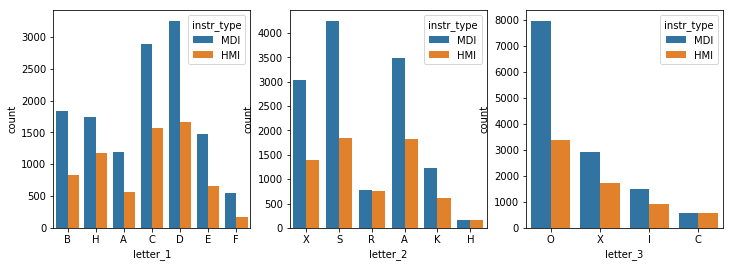

In [226]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
sns.countplot(df['letter_1'],hue = df['instr_type'],ax=ax1)
sns.countplot(df['letter_2'],hue = df['instr_type'],ax=ax2)
sns.countplot(df['letter_3'],hue = df['instr_type'],ax=ax3)

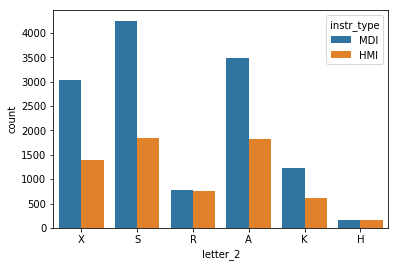

In [201]:
sns.countplot(df['letter_2'],hue = df['instr_type'])

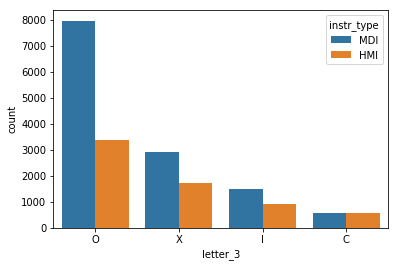

In [202]:
sns.countplot(df['letter_3'],hue = df['instr_type'])

In [ ]:
NOAA = 11084
sunspots.query('region =='+ str(NOAA))

In [ ]:
#pd.concat([hmi_df, sunspots]).sort_values(by='date')